# Deep Image Squish Predictor

This model takes a squished image as input and predicts whether its width or height has been squished, along with the squish ratio. For example, if an image is resized from `(w, h) = (256, 256)` to `(64, 128)`, the model output will be `(0.5, 1)`, which means the image width has been squished with rate `0.5`.

[huggingface](https://huggingface.co/erfanasgari21/deep-image-squish-predictor)
|
[github](https://github.com/erfanasgari21/Deep_Image_Squish_Predictors)

## Dataset Preparation

In [ ]:
!kaggle datasets download -d ifigotin/imagenetmini-1000
!unzip imagenetmini-1000.zip -d ./imagenetmini-1000

In [47]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

torch.manual_seed(42)

# Load the dataset
dataset_path = './imagenetmini-1000/imagenet-mini/'
train_dataset = ImageFolder(root=dataset_path+'train')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: x)
test_dataset = ImageFolder(root=dataset_path+'val')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: x)


Image Size and Aspect Ratio Analysis

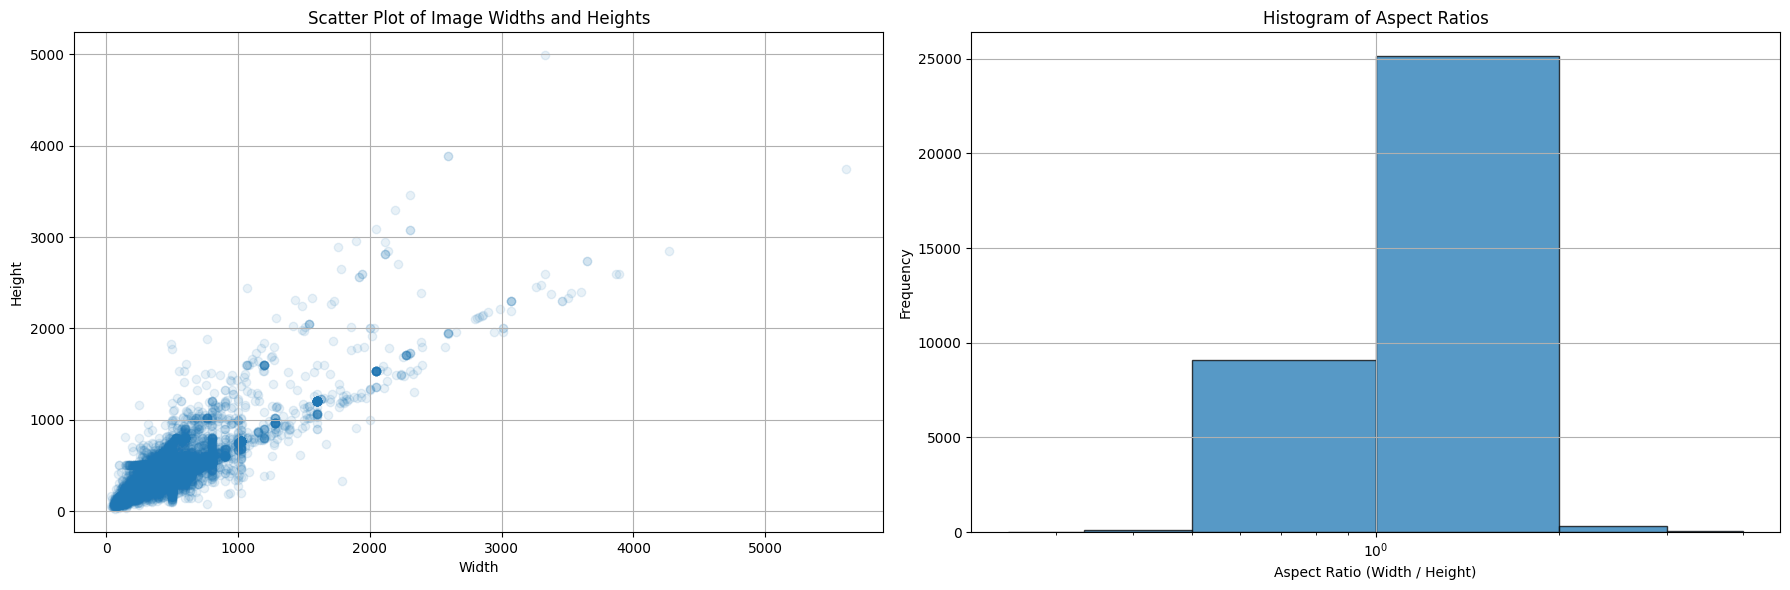

In [69]:
import numpy as np

# Helper function to get image sizes
def get_image_sizes(loader):
    widths = []
    heights = []
    for batch in loader:
        for img, _ in batch:
            width, height = img.size
            widths.append(width)
            heights.append(height)
    return widths, heights

# Get image sizes for train dataset
train_widths, train_heights = get_image_sizes(train_loader)

# Calculate aspect ratios
aspect_ratios = np.array(train_widths) / np.array(train_heights)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Scatter plot of image widths and heights
axes[0].scatter(train_widths, train_heights, alpha=0.1)
axes[0].set_xlabel('Width')
axes[0].set_ylabel('Height')
axes[0].set_title('Scatter Plot of Image Widths and Heights')
axes[0].grid(True)

# Histogram of aspect ratios
bins = [1/4, 1/3, 1/2, 1, 2, 3, 4]
axes[1].hist(aspect_ratios, bins=bins, edgecolor='black', alpha=0.75)
axes[1].set_xscale('log')
axes[1].set_xlabel('Aspect Ratio (Width / Height)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Aspect Ratios')
axes[1].grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()


## Self-Supervision Utility Functions
Random Crop and Random Squish

In [48]:
import random
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt


def random_crop(image, max_aspect_ratio=3):
    original_width, original_height = image.size
    original_ratio = original_width / original_height
    crop_ratio = random.uniform(1,max_aspect_ratio)
    crop_ratio = random.choice([1/crop_ratio, crop_ratio])

    if(crop_ratio < original_ratio):
      crop_height = original_height
      crop_width = int(original_height * crop_ratio)
    else:
      crop_width = original_width
      crop_height = int(original_width / crop_ratio)


    left = random.randint(0, original_width - crop_width)
    top = random.randint(0, original_height - crop_height)
    right = left + crop_width
    bottom = top + crop_height
    cropped_image = image.crop((left, top, right, bottom))

    return cropped_image

def random_squish(image, max_squish_ratio=3):
    width, height = image.size
    ratio = width / height
    squish_ratio = random.uniform(1,max_squish_ratio)
    squish_ratio = random.choice([1/squish_ratio , squish_ratio])

    if(squish_ratio < 1) :
      width = width * squish_ratio
      squish_index = (squish_ratio,1)
    else:
      height = height / squish_ratio
      squish_index = (1,1/squish_ratio)

    new_width, new_height = 256, 256
    if(squish_ratio*ratio < 1):
      new_width = int((256/height) * width)
    else:
      new_height = int((256/width) * height)

    squished_image = TF.resize(image, (new_height, new_width))

    # Zero-pad to fixed size (256x256)
    padded_image = Image.new("RGB", (256, 256))
    padded_image.paste(squished_image, (0, 0))

    return (padded_image, squish_index)


Visualize the process

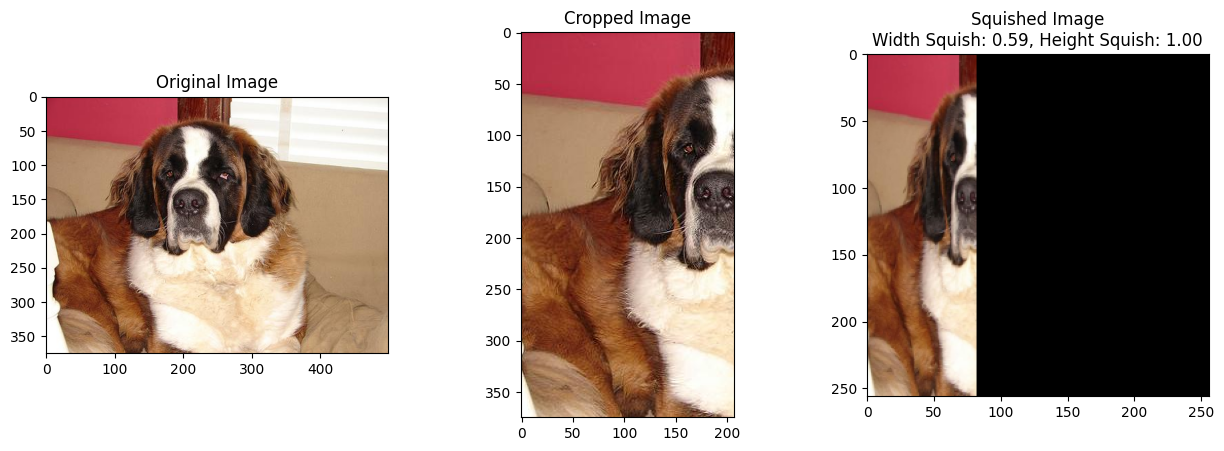

In [ ]:
# Get an image from the dataset
image, _ = train_dataset[8400]

# Process the image
cropped_image = random_crop(image)
squished_image, squish_ratio = random_squish(cropped_image)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original Image")

axes[1].imshow(cropped_image)
axes[1].set_title("Cropped Image")

axes[2].imshow(squished_image)
axes[2].set_title(f"Squished Image\nWidth Squish: {squish_ratio[0]:.2f}, Height Squish: {squish_ratio[1]:.2f}")

plt.show()



## Load the Pretrained Model
EfficientNet b4

In [ ]:
import torchvision.models as models
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained EfficientNet
model = models.efficientnet_b4(pretrained=True)

# Modify the final layer to output 2 values (width and height squish rates)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2)

model = model.to(device)

criterion = nn.MSELoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 107MB/s]


## Fine-tune

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import matplotlib.pyplot as plt

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

# Training loop
num_epochs = 3
loss_history = []

every_step = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}")

    for i, batch in progress_bar:
        inputs = [item[0] for item in batch]

        # Apply random squish
        squished_inputs, targets = zip(*[random_squish(random_crop(img)) for img in inputs])
        squished_inputs = torch.stack([TF.to_tensor(img) for img in squished_inputs]).to(device)
        targets = torch.tensor(targets, dtype=torch.float32).to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(squished_inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loss_history.append(loss.item())

        # Update progress bar
        if (i + 1) % every_step == 0:
            progress_bar.set_postfix({
                'Loss': running_loss / every_step,
                'Lr': scheduler.get_last_lr()[0]
            })
            running_loss = 0.0

    scheduler.step()

print('Finished Training')





Epoch 3: 100%|██████████| 1086/1086 [12:15<00:00,  1.48it/s, Loss=0.00611, Lr=1e-5]

Finished Training


NameError: name 'np' is not defined

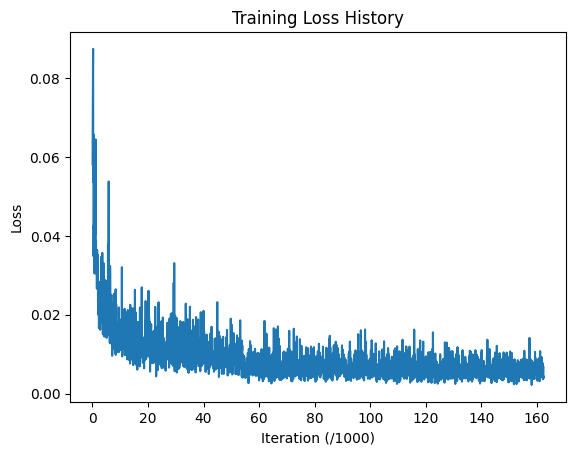

In [ ]:
# Plotting the loss history
plt.plot(torch.arange(1, len(loss_history[10:])+1)*every_step/1000, loss_history[10:])
plt.xlabel('Iteration (/1000)')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.show()

## Result Visualization

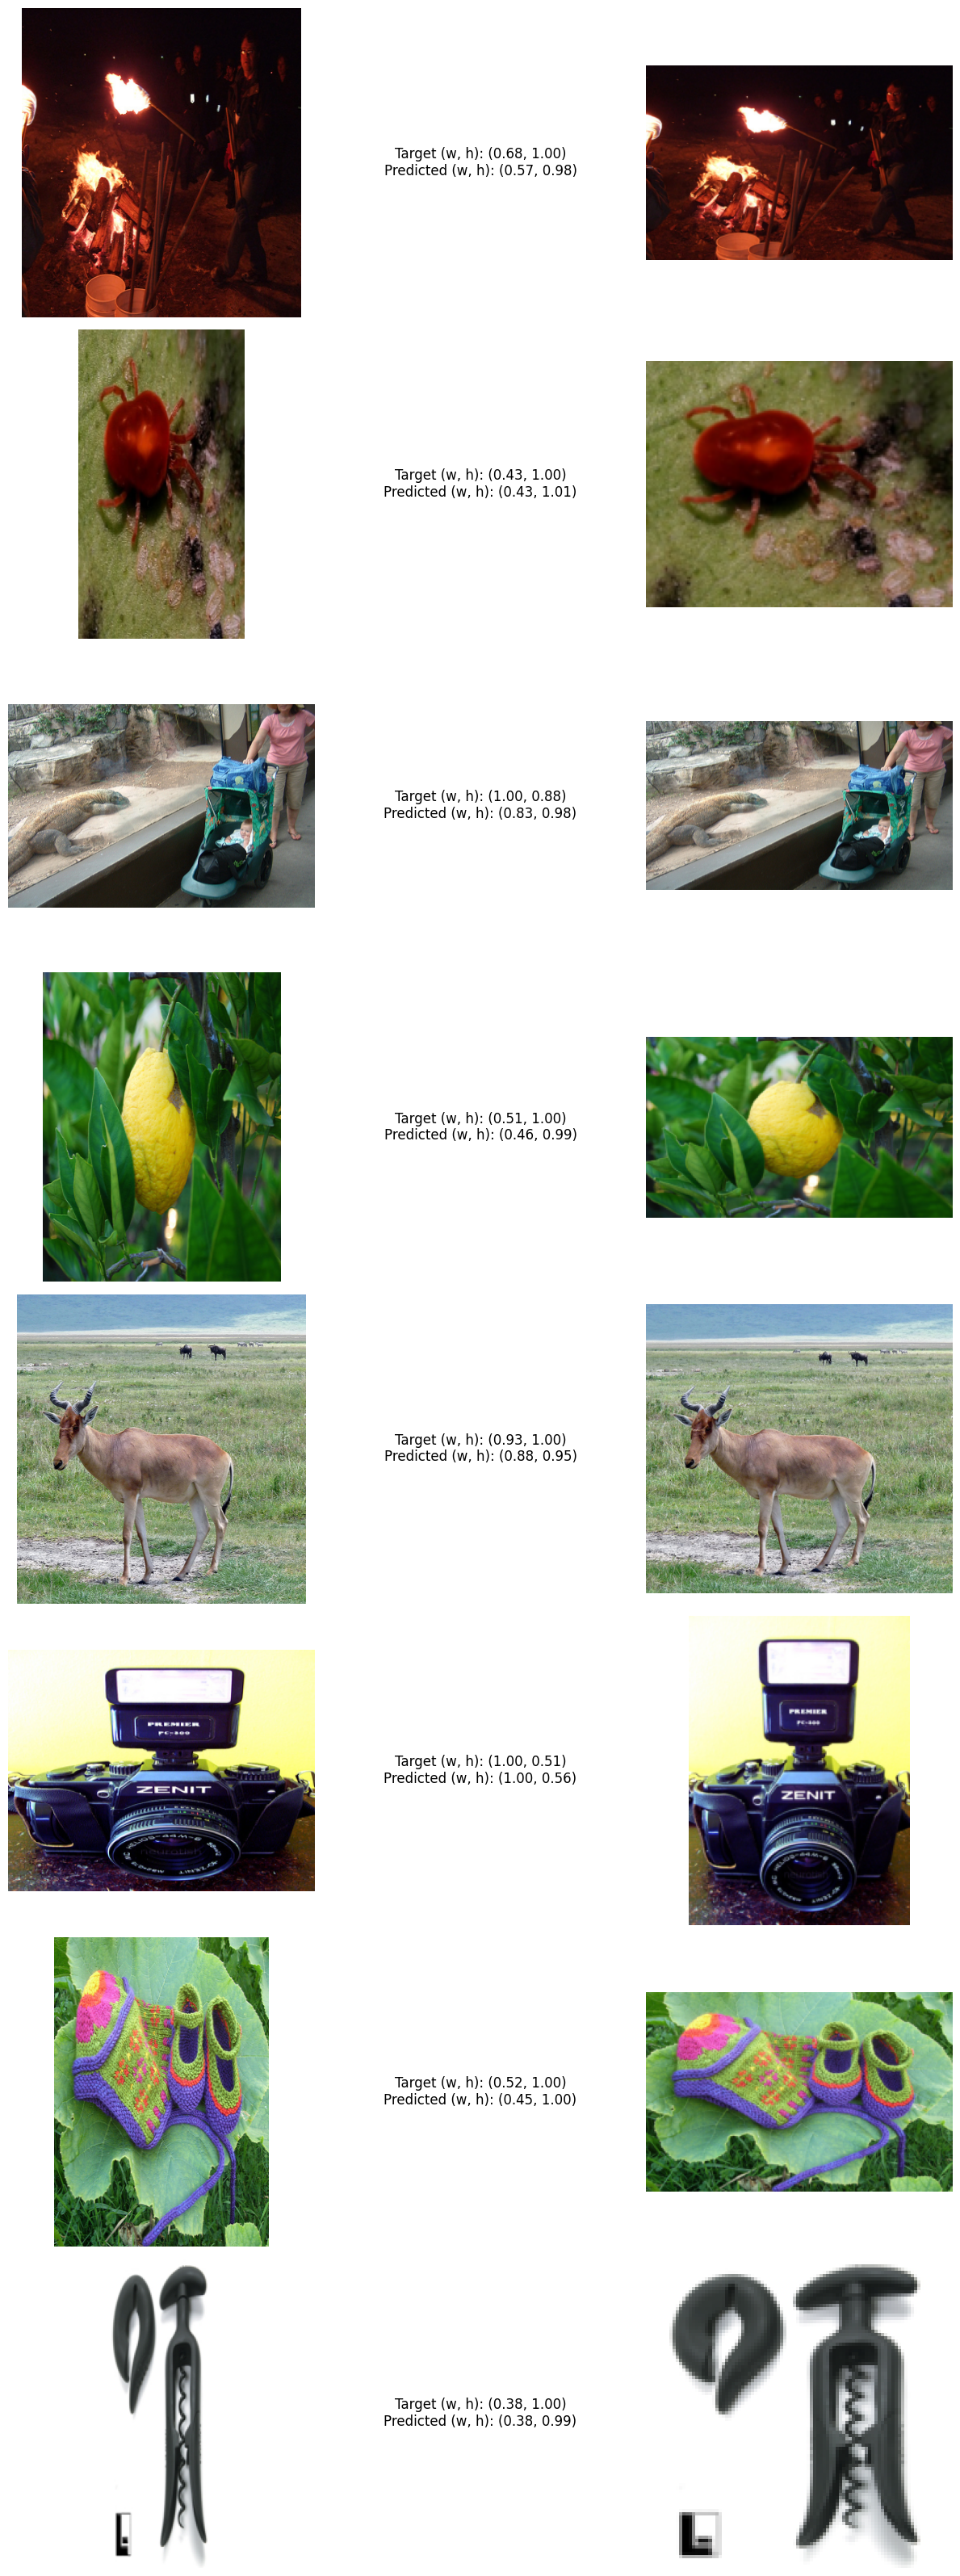

In [68]:
import matplotlib.pyplot as plt

# Visualization function
def visualize_predictions(model, dataset, device, num_images=32):
    model.eval()
    inputs = []
    targets = []
    reconstructeds = []
    predicted_ratios = []
    with torch.no_grad():
        for _ in range(num_images):
            # Randomly select an image from the dataset
            idx = random.randint(0, len(dataset) - 1)
            image, _ = dataset[idx]
            width, height = image.size

            squished_image, squish_ratio = random_squish(image)

            # Convert to tensor and add to list
            squished_tensor = TF.to_tensor(squished_image).unsqueeze(0).to(device)
            clean_squished_image = TF.resize(image, (int(height*squish_ratio[1]),int(width*squish_ratio[0])))
            inputs.append(clean_squished_image)
            targets.append(squish_ratio)

            # Predict squish ratio using the model
            predicted = model(squished_tensor)
            predicted = predicted.cpu().numpy().flatten()

            # Append predicted squish ratio to list
            predicted_ratios.append(predicted)

            width, height = clean_squished_image.size
            wsr, hsr = predicted.squeeze().tolist()
            if(wsr < hsr):
              height = int(height * wsr)
            else:
              width = int(width * hsr)
            reconstructed_image = TF.resize(clean_squished_image, (height, width))
            reconstructeds.append(reconstructed_image)

            if len(inputs) >= num_images:
                break

    # Plotting
    fig, axes = plt.subplots(8, 3, figsize=(12, 32))

    # Set titles for the first row

    for i in range(0, num_images):
        axes[i, 0].imshow(inputs[i])
        axes[i, 0].axis('off')
        axes[i, 1].text(0.5, 0.5, f"Target (w, h): ({targets[i][0]:.2f}, {targets[i][1]:.2f})\n"
                                 f"Predicted (w, h): ({predicted_ratios[i][0]:.2f}, {predicted_ratios[i][1]:.2f})", ha='center', va='center', fontsize=12)
        axes[i, 1].axis('off')
        axes[i, 2].imshow(reconstructeds[i])
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_predictions(model, test_dataset, 'cpu', num_images=8)


## Save the model in HuggingFace

In [27]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import torch
from transformers import AutoModel, AutoConfig
from huggingface_hub import HfApi, Repository

# Save your model and tokenizer
torch.save(model.state_dict(), "model.pth")

api = HfApi()
# Upload the model to Hugging Face Hub with a predefined repository name
repository_name = "deep-image-squish-predictor"
repo_url = api.create_repo(repository_name, exist_ok=True)
repo = Repository(local_dir="my_model_repo", clone_from=repo_url)

# Move the saved model to the repository directory
import shutil
shutil.move("model.pth", "my_model_repo/deep-image-squish-predictor-V0.pth")

repo.push_to_hub(commit_message="Initial commit")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/erfanasgari21/deep-image-squish-predictor into local empty directory.


Upload file deep-image-squish-predictor-V0.pth:   0%|          | 1.00/67.6M [00:00<?, ?B/s]

To https://huggingface.co/erfanasgari21/deep-image-squish-predictor
   a5cd145..320bedb  main -> main

   a5cd145..320bedb  main -> main



'https://huggingface.co/erfanasgari21/deep-image-squish-predictor/commit/320bedbbc07a57d7f5baa89893132360feb71700'

Load the model from hub

In [2]:
import torchvision.models as models
import torch.nn as nn

# Load pre-trained EfficientNet
model = models.efficientnet_b4()

# Modify the final layer to output 2 values (width and height squish rates)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2)

In [4]:
import torch
from transformers import AutoModel, AutoConfig
from huggingface_hub import HfApi, Repository

api = HfApi()
repository_name = "deep-image-squish-predictor"
repo_url = api.create_repo(repository_name, exist_ok=True)
repo = Repository(local_dir="my_model_repo", clone_from=repo_url)
model.load_state_dict(torch.load("my_model_repo/deep-image-squish-predictor-V0.pth", map_location=torch.device('cpu')))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message,

Download file deep-image-squish-predictor-V0.pth:   0%|          | 1.40k/67.6M [00:00<?, ?B/s]

Clean file deep-image-squish-predictor-V0.pth:   0%|          | 1.00k/67.6M [00:00<?, ?B/s]